## Connect to Drive

We need to connect to Google Drive to pull down the images and libraries that form the training environment.

In [0]:
!rm -rf sample_data

In [0]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
def connect_drive():
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  return drive

In [0]:
drive = connect_drive()

## Import Required Directories into Colab

Move data directories and other requirements from drive into colab.



In [0]:
root_id = '1AMna4-DCv3oq241ZS4jtYm3dKdeeBzxQ'
df_csv_string = 'df.csv'
images_zip_string = 'images.zip'

In [0]:
# Helper functions for pulling in data to colabs

def get_files_in_drive_folder(folder_id, drive):
  return drive.ListFile({'q': "'{}' in parents".format(folder_id)}).GetList()
      
def is_folder(file):
  return file['mimeType'] == 'application/vnd.google-apps.folder'

In [0]:
file_list = get_files_in_drive_folder(root_id, drive)
for file in file_list:
  if not is_folder(file):
    file.GetContentFile(file['title'])

## Setup

Handle imports and environment setup

In [0]:
import pandas as pd

df = pd.read_csv(df_csv_string)

In [57]:
!unzip "$images_zip_string"

Archive:  images.zip
replace images/8071484-389047.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
!python -c "import tensorflow.contrib.gan as tfgan"

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import functools
from six.moves import xrange 

import tensorflow as tf

# Shortcuts
tfgan = tf.contrib.gan
queues = tf.contrib.slim.queues
layers = tf.contrib.layers
ds = tf.contrib.distributions
framework = tf.contrib.framework

### Evaluation Functions

These functions are used to evaluate GANs during training, but also to verify things are working as they should be as we set up our models.

In [0]:
leaky_relu = lambda net: tf.nn.leaky_relu(net, alpha=0.01)
  

def visualize_training_generator(train_step_num, start_time, data_np):
    """Visualize generator outputs during training.
    
    Args:
        train_step_num: The training step number. A python integer.
        start_time: Time when training started. The output of `time.time()`. A
            python float.
        data: Data to plot. A numpy array, most likely from an evaluated TensorFlow
            tensor.
    """
    
    print('Training step: %i' % train_step_num)
    time_since_start = (time.time() - start_time) / 60.0
    print('Time since start: %f m' % time_since_start)
    print('Steps per min: %f' % (train_step_num / time_since_start))
    
    ###HACKED CODE TO GET IMAGES TO DISPLAY NICELY vvv 
    
    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(111)

    ax.imshow(np.squeeze(data_np), cmap='gray')
    #ax.set_aspect('auto')
    plt.axis('off')
    plt.show()
    
    # HACKED CODE TO GET IMAGES TO DISPLAY NICELY ^^^
    #plt.axis('off')
    #plt.imshow(np.squeeze(data_np), cmap='gray')
    #plt.show()

    
def visualize_tensor(tensor_to_visualize):
    """Visualize an image once. Used to visualize generator before training.
    
    Args:
        tensor_to_visualize: An image tensor to visualize. A python Tensor.
    """
    
    print(tensor_to_visualize.shape)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        with queues.QueueRunners(sess):
            images_np = sess.run(tensor_to_visualize)
            print('THIS SHOULD PROBABLY BE A NUMPY ARRAY:', type(images_np))
    
    
    ###HACKED CODE TO GET IMAGES TO DISPLAY NICELY vvv 
    
    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(111)

    ax.imshow(np.squeeze(images_np), cmap='gray')
    #ax.set_aspect('auto')
    plt.axis('off')
    plt.show()
    
    # HACKED CODE TO GET IMAGES TO DISPLAY NICELY ^^^
   # plt.imshow(np.squeeze(images_np), cmap='gray')

    
def evaluate_tfgan_loss(gan_loss, name=None):
    """Evaluate GAN losses. Used to check that the graph is correct.
    
    Args:
        gan_loss: A GANLoss tuple.
        name: Optional. If present, append to debug output.
    """
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        with queues.QueueRunners(sess):
            gen_loss_np = sess.run(gan_loss.generator_loss)
            dis_loss_np = sess.run(gan_loss.discriminator_loss)
    if name:
        print('%s generator loss: %f' % (name, gen_loss_np))
        print('%s discriminator loss: %f'% (name, dis_loss_np))
    else:
        print('Generator loss: %f' % gen_loss_np)
        print('Discriminator loss: %f'% dis_loss_np)

During training, the generator tries to produce realistic-enough images to 'fool' a discriminator network, while the discriminator tries to distinguish real digits from generated ones. See the paper ['NIPS 2016 Tutorial: Generative Adversarial Networks'](https://arxiv.org/pdf/1701.00160.pdf) by Goodfellow or ['Generative Adversarial Networks'](https://arxiv.org/abs/1406.2661) by Goodfellow et al. for more details.

From the tutorial: the steps to using TFGAN to set up an unconditional GAN, in the simplest case, are as follows:

1. **Model**: Set up the generator and discriminator graphs with a [`GANModel`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/namedtuples.py#L39) tuple. Use [`tfgan.gan_model`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/train.py#L64) or create one manually.
1. **Losses**: Set up the generator and discriminator losses with a [`GANLoss`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/namedtuples.py#L115) tuple. Use [`tfgan.gan_loss`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/train.py#L328) or create one manually.
1. **Train ops**: Set up TensorFlow ops that compute the loss, calculate the gradients, and update the weights with a [`GANTrainOps`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/namedtuples.py#L128) tuple. Use [`tfgan.gan_train_ops`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/train.py#L476) or create one manually.
1. **Run alternating train loop**: Run the training Ops. This can be done with [`tfgan.gan_train`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/train.py#L661), or done manually.

Each step can be performed by a TFGAN library call, or can be constructed manually for more control.

<a id='unconditional_input'></a>
## Data Input Pipeline

In [0]:
from PIL import Image
from sklearn.utils import shuffle
class DataFrameImageDataGenerator():
  
  def __init__(self, df):
    '''DataFrameImageDataGenerator takes a dataframe with local image paths attached
       and builds a datapoint generator that returns TensorFlow tensors, including any
       features from the DataFrames columns as well as a tensor for the image'''
    self.df = df
    
    #shuffle dataframe
    self.df = shuffle(self.df)
    
  def _row_generator(self):
    '''Returns a generator that loops through the entire dataset'''
    
    for i in range(0, len(self.df)):
      yield (df.iloc[i]['path'])
      
  #set up a subgraph that reads the path and decodes into an image
  def _get_row_image(self, b_string):
      img = tf.read_file(b_string)
      img = tf.image.decode_jpeg(img, channels=1)
      return img
    
  def _normalize(self, img):
    img = tf.cast(img, tf.float32)
    img = (img - 128.0)/128.0
    return img
  
  #currently just provides image data
  def data_provider(self, batch_size=32, num_epochs=1, num_image_processors=16, num_normalizers=16, num_prefetchers=(1, 1, 1)):
    dataset = tf.data.Dataset.from_generator(self._row_generator, (tf.string), output_shapes=(None))
    dataset = dataset.repeat(num_epochs)
    
    dataset = dataset.prefetch(num_prefetchers[0])


    dataset = dataset.map(self._get_row_image, num_parallel_calls=num_image_processors)
    #preprocess
    dataset = dataset.prefetch(num_prefetchers[1])

    dataset = dataset.map(self._normalize, num_parallel_calls=num_normalizers)
    
    #buffer
    dataset = dataset.prefetch(num_prefetchers[2])
    
    #drop remainder so batches have consistent size!
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset
    
  

In [62]:
#TESTING
data_provider = DataFrameImageDataGenerator(df).data_provider()
iterator = data_provider.make_one_shot_iterator()

with tf.Session() as sess:
  x = sess.run(iterator.get_next())
  
print(x.shape)

(32, 120, 120, 1)


creating data pipeline!
(1, 240, 960, 1)
THIS SHOULD PROBABLY BE A NUMPY ARRAY: <class 'numpy.ndarray'>


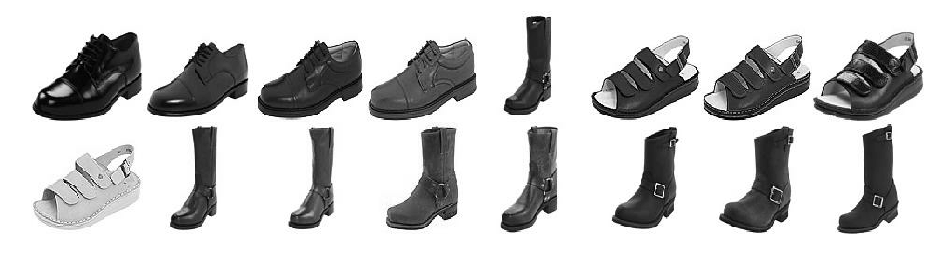

In [63]:
tf.reset_default_graph()
# Define our input pipeline. Pin it to the CPU so that the GPU can be reserved
# for forward and backwards propogation.

print('creating data pipeline!')

num_epochs = 20
batch_size = 32
num_training_steps = num_epochs*len(df)

with tf.device('/cpu:0'):
    iterator = DataFrameImageDataGenerator(df).data_provider(batch_size=batch_size, num_epochs=num_epochs).make_one_shot_iterator()
    real_images = iterator.get_next()
    
    ### HACK TO SET THE STATIC SHAPE OF real_images TO (BATCH_SIZE, IMG_WIDTH, IMG_HEIGHT, NUM_CHANNELS)
    real_images.set_shape((32, 120, 120, 1))

# Sanity check that we're getting images.
check_real_images = tfgan.eval.image_reshaper(
    real_images[:16,...], num_cols=8)
visualize_tensor(check_real_images)

<a id='unconditional_model'></a>
## Model

Set up a [GANModel tuple](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/namedtuples.py#L39), which defines everything we need to perform GAN training. You can create the tuple with the library functions, or you can manually create one.

Define the GANModel tuple using the TFGAN library function.
For the simplest case, we need the following:

1. A generator function that takes input noise and outputs generated MNIST digits

1. A discriminator function that takes images and outputs a probability of  being real or fake

1. Real images

1. A noise vector to pass to the generator

### Generator

In [0]:
def generator_fn(noise, weight_decay=2.5e-5, is_training=True):
    """Simple generator to produce MNIST images.
    
    Args:
        noise: A single Tensor representing noise.
        weight_decay: The value of the l2 weight decay.
        is_training: If `True`, batch norm uses batch statistics. If `False`, batch
            norm uses the exponential moving average collected from population 
            statistics.
    
    Returns:
        A generated image in the range [-1, 1].
    """
    
    num_to_fix_dims = 120//4
    nr = num_to_fix_dims
    with framework.arg_scope(
        [layers.fully_connected, layers.conv2d_transpose],
        activation_fn=tf.nn.relu, normalizer_fn=layers.batch_norm,
        weights_regularizer=layers.l2_regularizer(weight_decay)),\
    framework.arg_scope([layers.batch_norm], is_training=is_training,
                        zero_debias_moving_mean=True):
        net = layers.fully_connected(noise, 1024)
        net = layers.fully_connected(net, nr * nr * 256)
        net = tf.reshape(net, [-1, nr, nr, 256])
        net = layers.conv2d_transpose(net, 64, [4, 4], stride=2)
        net = layers.conv2d_transpose(net, 32, [4, 4], stride=2)
        # Make sure that generator output is in the same range as `inputs`
        # ie [-1, 1].
        print(net.shape)
        net = layers.conv2d(net, 1, 4, normalizer_fn=None, activation_fn=tf.tanh)

        return net

### Discriminator

In [0]:
def discriminator_fn(img, unused_conditioning, weight_decay=2.5e-5,
                     is_training=True):
    """Discriminator network on MNIST digits.
    
    Args:
        img: Real or generated MNIST digits. Should be in the range [-1, 1].
        unused_conditioning: The TFGAN API can help with conditional GANs, which
            would require extra `condition` information to both the generator and the
            discriminator. Since this example is not conditional, we do not use this
            argument.
        weight_decay: The L2 weight decay.
        is_training: If `True`, batch norm uses batch statistics. If `False`, batch
            norm uses the exponential moving average collected from population 
            statistics.
    
    Returns:
        Logits for the probability that the image is real.
    """
    with framework.arg_scope(
        [layers.conv2d, layers.fully_connected],
        activation_fn=leaky_relu, normalizer_fn=None,
        weights_regularizer=layers.l2_regularizer(weight_decay),
        biases_regularizer=layers.l2_regularizer(weight_decay)):
        net = layers.conv2d(img, 64, [4, 4], stride=2)
        net = layers.conv2d(net, 128, [4, 4], stride=2)
        net = layers.flatten(net)
        with framework.arg_scope([layers.batch_norm], is_training=is_training):
            net = layers.fully_connected(net, 1024, normalizer_fn=layers.batch_norm)
        return layers.linear(net, 1)

### GANModel Tuple

(32, 120, 120, 32)
(1, 240, 1200, 1)
THIS SHOULD PROBABLY BE A NUMPY ARRAY: <class 'numpy.ndarray'>


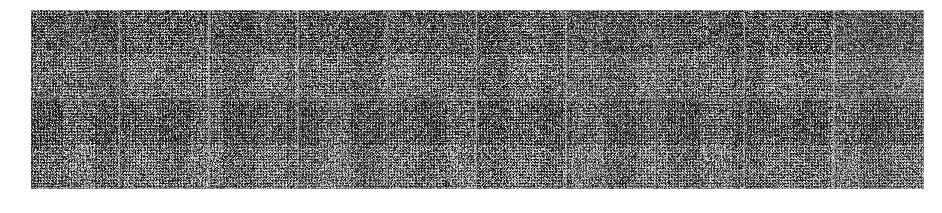

In [66]:
noise_dims = 64 
#APPEARS THERE'S A PROBLEM WITH THE WEIGHTS?

#this is where the real_data gets passed in (As a tensor)


##### PROBLEM WITH PASSING DISCRIMINATOR ARGUMENTS... APPARENTLY SPECIFIED INT_64??
gan_model = tfgan.gan_model(
    generator_fn,
    discriminator_fn,
    real_data=real_images,
    generator_inputs=tf.random_normal([batch_size, noise_dims]))

# Sanity check that generated images before training are garbage.
check_generated_digits = tfgan.eval.image_reshaper(
    gan_model.generated_data[:20,...], num_cols=10)
visualize_tensor(check_generated_digits)

<a id='unconditional_loss'></a>
## Losses

We next set up the GAN model losses.

Loss functions are currently an active area of research. The [losses library](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/losses/python/losses_impl.py) provides some well-known or successful loss functions, such as the [original minimax](https://arxiv.org/abs/1406.2661), [Wasserstein](https://arxiv.org/abs/1701.07875) (by Arjovsky et al), and [improved Wasserstein](https://arxiv.org/abs/1704.00028) (by Gulrajani et al) losses. It is easy to add loss functions to the library as they are developed, and you can also pass in a custom loss function.

In [67]:
# We can use the minimax loss from the original paper.
vanilla_gan_loss = tfgan.gan_loss(
    gan_model,
    generator_loss_fn=tfgan.losses.minimax_generator_loss,
    discriminator_loss_fn=tfgan.losses.minimax_discriminator_loss)

# We can use the Wasserstein loss (https://arxiv.org/abs/1701.07875) with the 
# gradient penalty from the improved Wasserstein loss paper 
# (https://arxiv.org/abs/1704.00028).
improved_wgan_loss = tfgan.gan_loss(
    gan_model,
    # We make the loss explicit for demonstration, even though the default is 
    # Wasserstein loss.
    generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
    discriminator_loss_fn=tfgan.losses.wasserstein_discriminator_loss,
    gradient_penalty_weight=1.0)

# We can also define custom losses to use with the rest of the TFGAN framework.
def silly_custom_generator_loss(gan_model, add_summaries=False):
    return tf.reduce_mean(gan_model.discriminator_gen_outputs)
def silly_custom_discriminator_loss(gan_model, add_summaries=False):
    return (tf.reduce_mean(gan_model.discriminator_gen_outputs) -
            tf.reduce_mean(gan_model.discriminator_real_outputs))
custom_gan_loss = tfgan.gan_loss(
    gan_model,
    generator_loss_fn=silly_custom_generator_loss,
    discriminator_loss_fn=silly_custom_discriminator_loss)

# Sanity check that we can evaluate our losses.
for gan_loss, name in [(vanilla_gan_loss, 'vanilla loss'), 
                       (improved_wgan_loss, 'improved wgan loss'), 
                       (custom_gan_loss, 'custom loss')]:
    evaluate_tfgan_loss(gan_loss, name)

vanilla loss generator loss: -1.021314
vanilla loss discriminator loss: 1.491925
improved wgan loss generator loss: 0.104901
improved wgan loss discriminator loss: 0.187658
custom loss generator loss: 0.027394
custom loss discriminator loss: 0.016663


<a id='unconditional_train'></a>
## Training and Evaluation

### Train Ops
In order to train a GAN, we need to train both generator and discriminator networks using some variant of the alternating training paradigm. To do this, we construct a [GANTrainOps tuple](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/namedtuples.py#L128) either manually or with a library call. We pass it the optimizers that we want to use, as well as any extra arguments that we'd like passed to slim's `create_train_op` function.

In [68]:
generator_optimizer = tf.train.AdamOptimizer(0.001, beta1=0.5)
discriminator_optimizer = tf.train.AdamOptimizer(0.0001, beta1=0.5)
gan_train_ops = tfgan.gan_train_ops(
    gan_model,
    improved_wgan_loss,
    generator_optimizer,
    discriminator_optimizer)

### Evaluation

TFGAN provides some standard methods of evaluating generative models. In this example, we use a pre-trained classifier to calculate what is called the 'Inception Score' from [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) (by Salimans et al), which is a combined score of quality and diversity. We also calculate the 'Frechet Inception distance' from [GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium](https://arxiv.org/abs/1706.08500) (by Heusel et al), which measures how close the generated image distribution is to the real image distribution. 

### We aren't evaluating ShoeGAN just yet and this is left in for reference. Markdown'd version of evaluating MNIST. See Tutorial notebook for removed steps for MNIST to get an idea of how to evaluate ShoeGAN (will probably need to train a shoe not-shoe classifier).

In [0]:
#inception score probably just takes a classifier that already works on the right distribution 
#and sees how it does on this new distribution. Kind of like an analogy between probability
#and likelihood. The score represents... 

In [70]:
# EVALUATION: Reshape eval images for viewing.


num_images_to_eval = 16
# For variables to load, use the same variable scope as in the train job.
with tf.variable_scope('Generator', reuse=True):
    eval_images = gan_model.generator_fn(
        tf.random_normal([num_images_to_eval, noise_dims]),
        is_training=False)
    
    
generated_data_to_visualize = tfgan.eval.image_reshaper(
    eval_images[:16,...], num_cols=8)

(16, 120, 120, 32)


### Train Steps

Now we're ready to train. TFGAN handles the alternating training scheme that arises from the GAN minmax game. It also gives you the option of changing the ratio of discriminator updates to generator updates. Most applications (distributed setting, borg, etc) will use the [`gan_train`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/train.py#L661) function, but we will use a different TFGAN utility and manually run the train ops so we can introspect more.

This code block should take about **1 minute** to run on a GPU kernel, and about **8 minutes** on CPU.

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Current loss: -0.127544
Training step: 0
Time since start: 0.035318 m
Steps per min: 0.000000


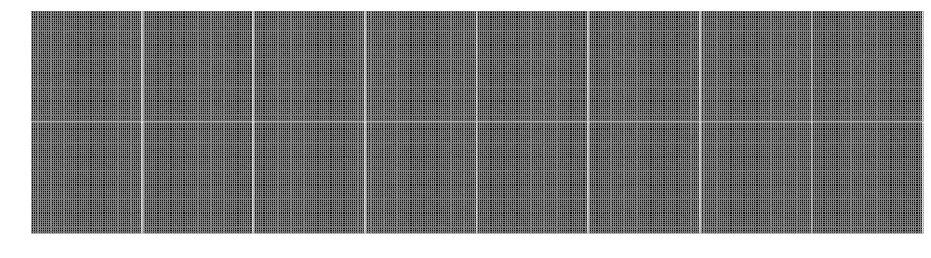

Current loss: -1.020419
Training step: 200
Time since start: 2.250039 m
Steps per min: 88.887343


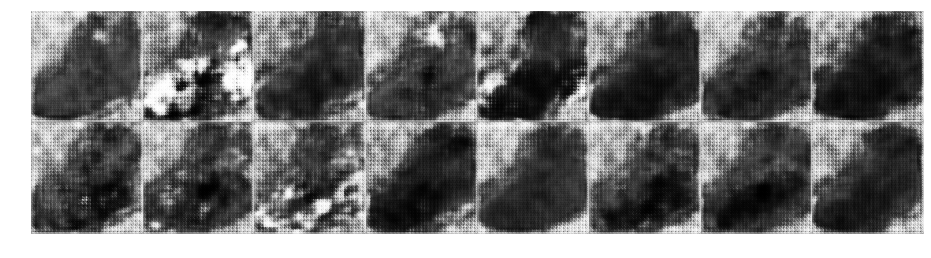

Current loss: -0.352142
Training step: 400
Time since start: 4.468175 m
Steps per min: 89.522013


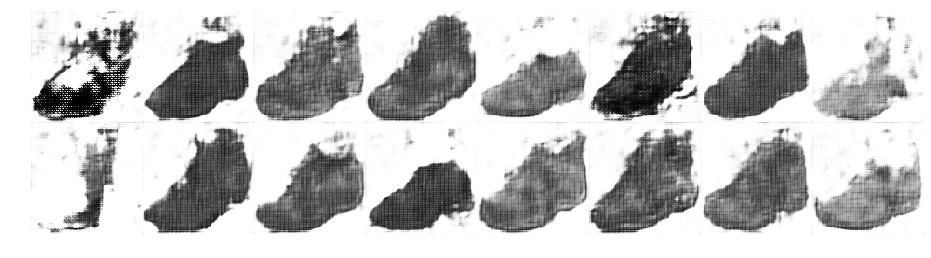

Current loss: -13.989377
Training step: 600
Time since start: 6.683907 m
Steps per min: 89.767853


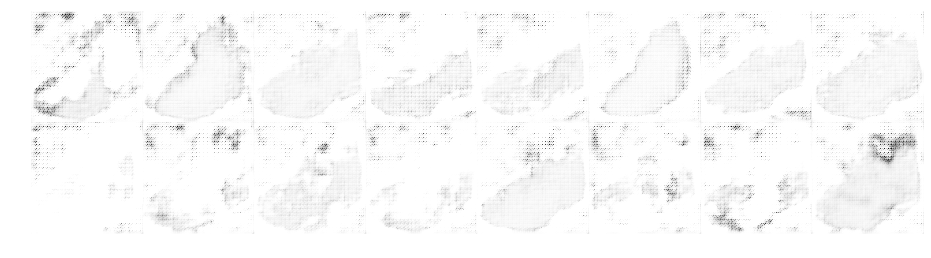

Current loss: -4.205388
Training step: 800
Time since start: 8.898689 m
Steps per min: 89.900879


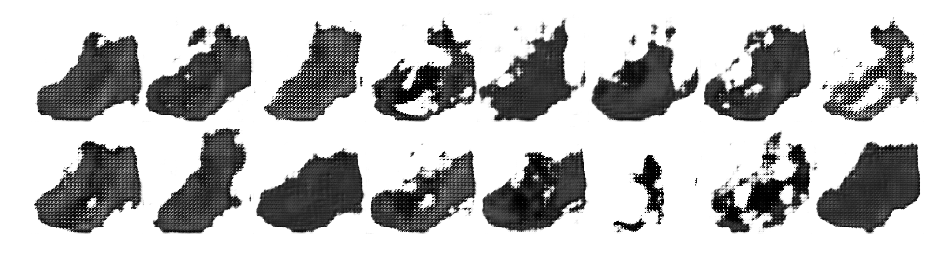

Current loss: -0.780735
Training step: 1000
Time since start: 11.125090 m
Steps per min: 89.886917


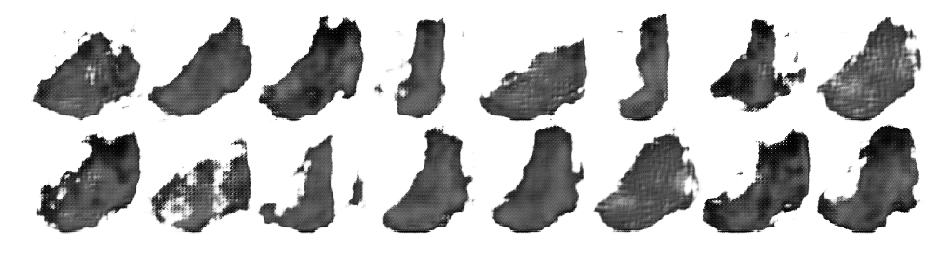

Current loss: 1.885142
Training step: 1200
Time since start: 13.354979 m
Steps per min: 89.854126


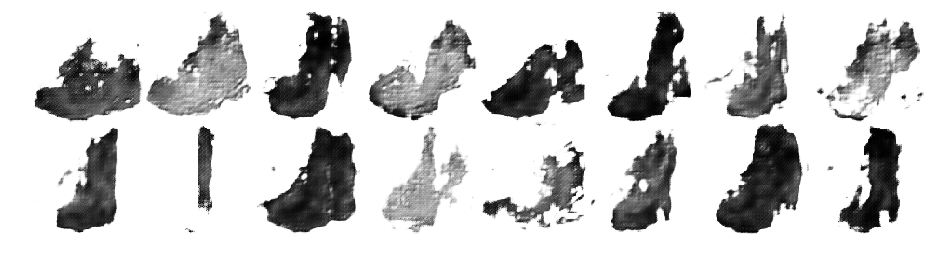

Current loss: 2.591344
Training step: 1400
Time since start: 15.584625 m
Steps per min: 89.832125


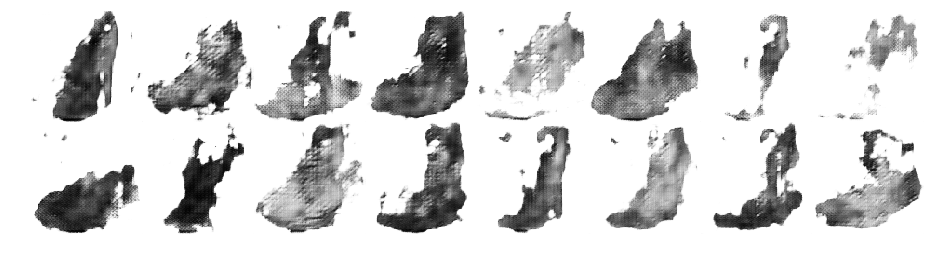

Current loss: -3.491419
Training step: 1600
Time since start: 17.807343 m
Steps per min: 89.850576


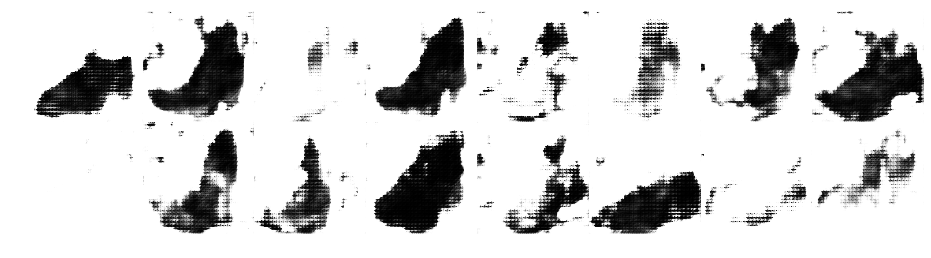

Current loss: 2.076446
Training step: 1800
Time since start: 20.032997 m
Steps per min: 89.851760


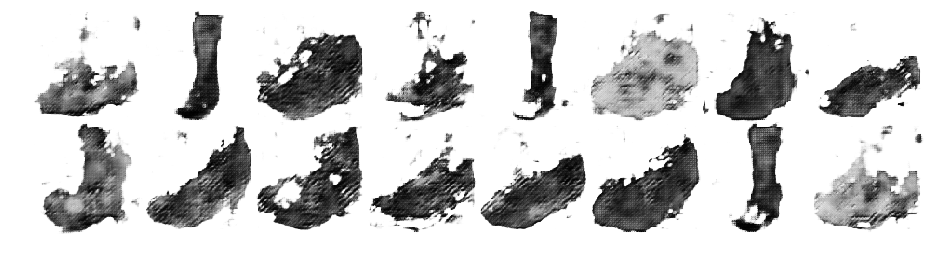

Current loss: 0.945986
Training step: 2000
Time since start: 22.263799 m
Steps per min: 89.831928


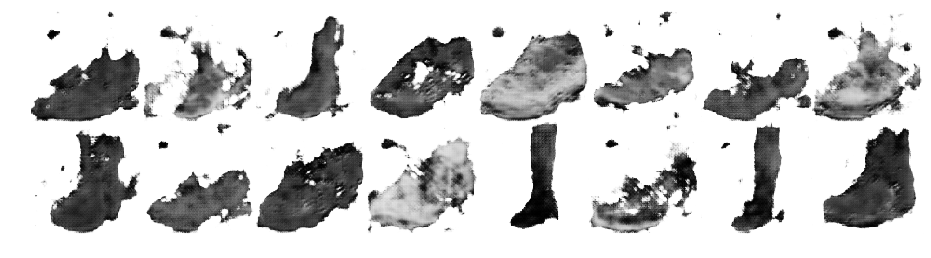

Current loss: 2.541644
Training step: 2200
Time since start: 24.539065 m
Steps per min: 89.652967


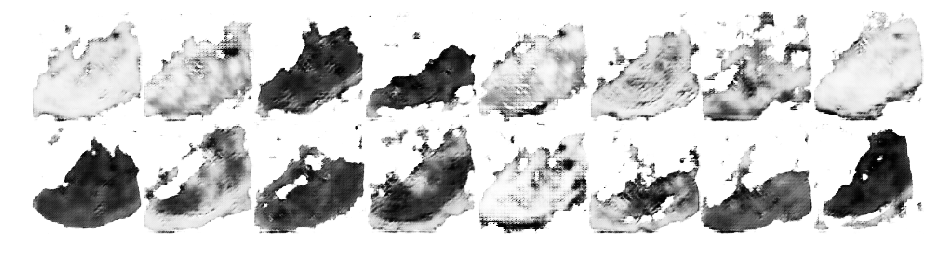

Current loss: 3.919143
Training step: 2400
Time since start: 26.812022 m
Steps per min: 89.512086


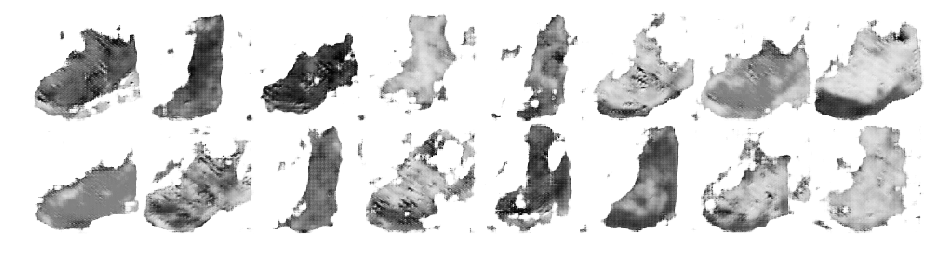

Current loss: 2.926303
Training step: 2600
Time since start: 29.074451 m
Steps per min: 89.425593


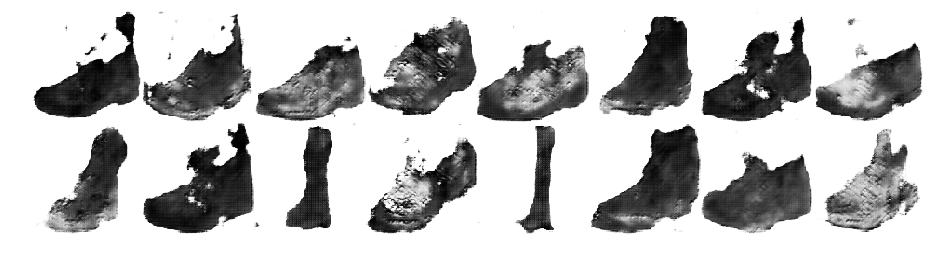

Current loss: 4.933004
Training step: 2800
Time since start: 31.338681 m
Steps per min: 89.346455


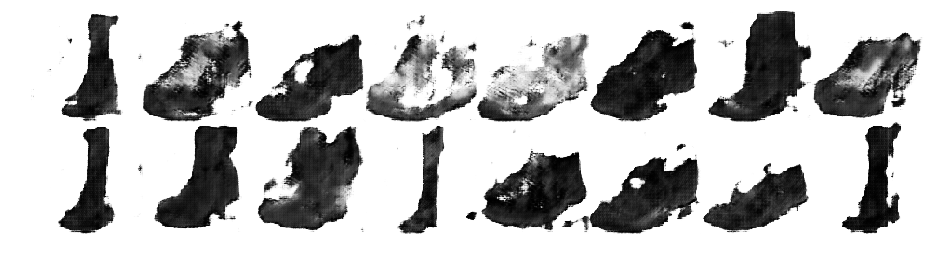

Current loss: -8.141276
Training step: 3000
Time since start: 33.596367 m
Steps per min: 89.295369


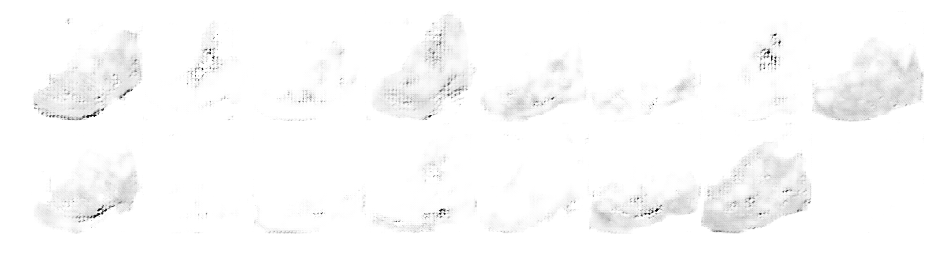

Current loss: -2.314150
Training step: 3200
Time since start: 35.857223 m
Steps per min: 89.242829


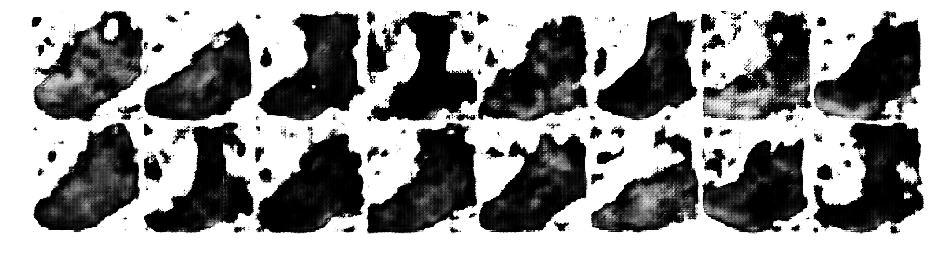

In [0]:


# We have the option to train the discriminator more than one step for every 
# step of the generator. In order to do this, we use a `GANTrainSteps` with 
# desired values. For this example, we use the default 1 generator train step 
# for every discriminator train step.
train_step_fn = tfgan.get_sequential_train_steps()

global_step = tf.train.get_or_create_global_step()
loss_values, mnist_scores, frechet_distances  = [], [], []

with tf.train.SingularMonitoredSession() as sess:
    start_time = time.time()
    for i in xrange(num_training_steps):
        cur_loss, _ = train_step_fn(
            sess, gan_train_ops, global_step, train_step_kwargs={})
        loss_values.append((i, cur_loss))
        if i % 200 == 0:
            shoes_np = sess.run([generated_data_to_visualize])
            print('Current loss: %f' % cur_loss)
            visualize_training_generator(i, start_time, shoes_np)

In [0]:
# CLEAN UP CODE... PULL FUNCTIONALITY INTO .py FILES


#### TODO:


# Get this running on colab. (Should be easy...)
    # Pull up the relevant files
    # Copy the code across
    


# ENSURE IMAGES ARE BEING SCALED BETWEEN -1 AND 1... as in... that that's what
# the network is seeing.

### TRY WITH BIGGER IMAGES and MORE COMPLEX ARCHITECTURES (hopefully you've made that first part easy for yo'self)

# BUILD SHOE SPACE and possibly PERFECT SHOE CALCULATOR (USING MEAN OF INTERESTED SHOES)